## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [1]:
from tqdm import tqdm_notebook
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import torch

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [4]:
from torchvision.transforms.transforms import Resize
class DogsDataset(Dataset):
    """
    Images dataset which loads them from the directories and make their scaling
    and converting to tensors.
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.transform = transform if transform != None else transforms.Compose([
              transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
TRAIN_DIR = Path('data/train/')
TEST_DIR = Path('data/test/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

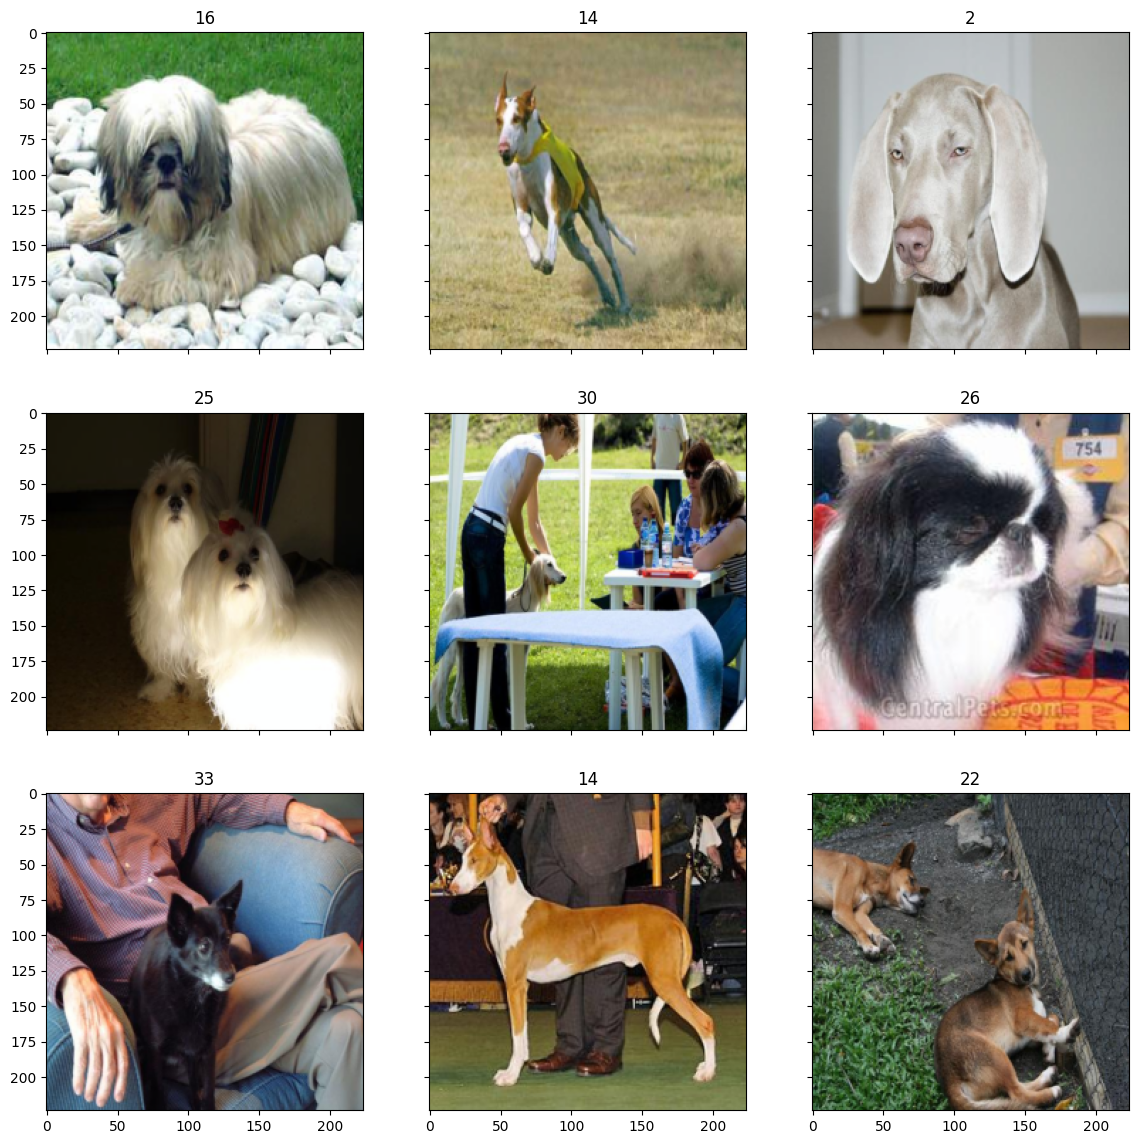

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
val_dataset = DogsDataset(val_files, mode='val')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [8]:
len(train_files)

5374

In [9]:
transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=45),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])

In [10]:
augmented = DogsDataset(train_files, 'train', transform=transform) 

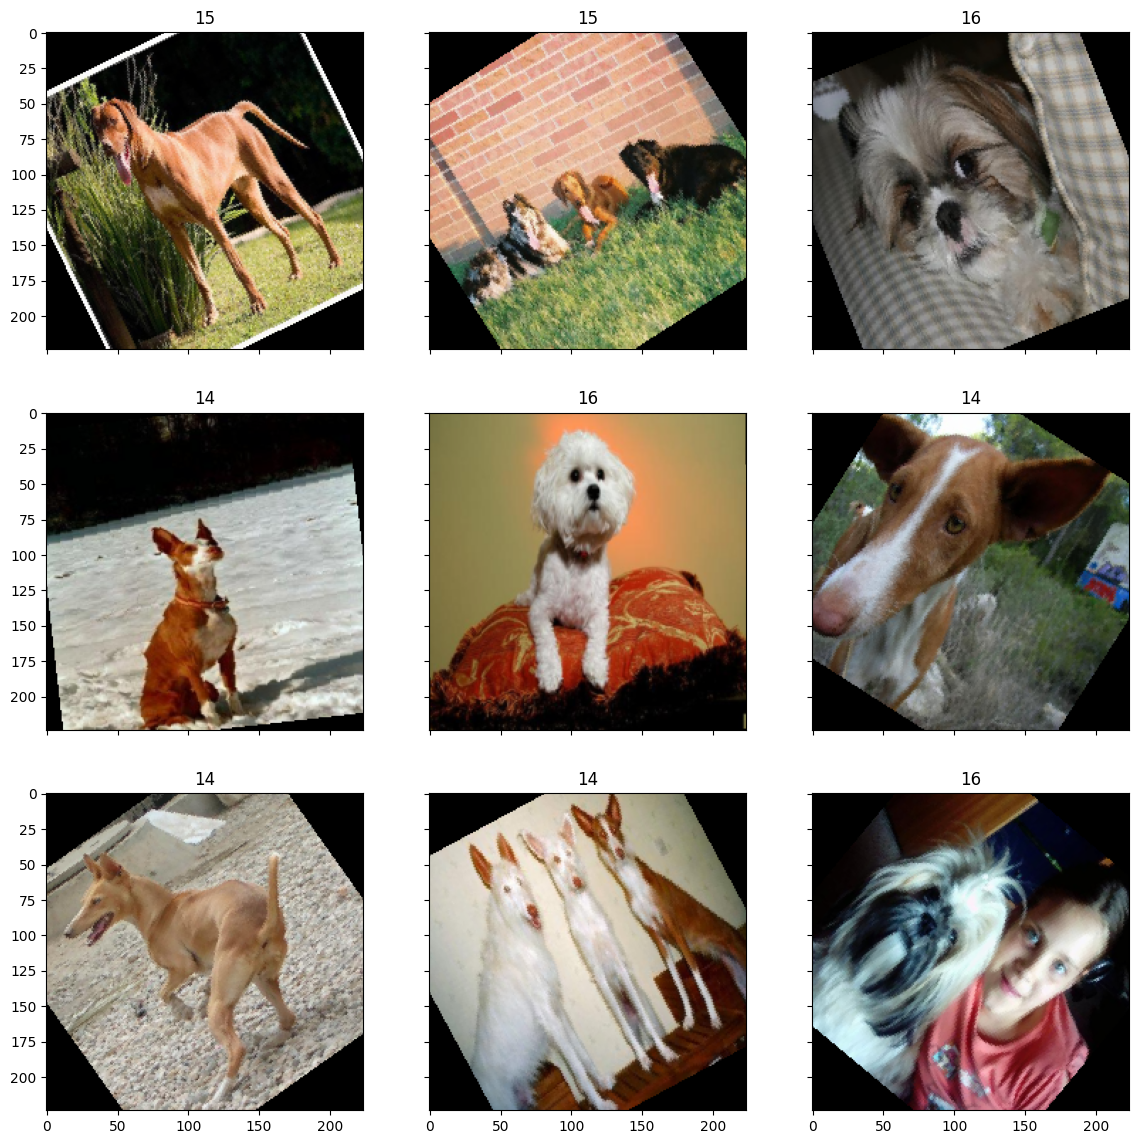

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = augmented[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                augmented.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [12]:
import torchvision
from torch.optim import lr_scheduler
import time
from collections.abc import Callable, Iterable

In [13]:
model101 = torchvision.models.resnet101(weights="IMAGENET1K_V1").to(DEVICE)
model101.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
def plot_epoch(history: list):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    ax[0].plot(train_loss, label='train_loss', color="red")
    ax[0].plot(val_loss, label='val_loss', color="blue")
    ax[1].plot(train_acc, label='train_acc', color="green")
    ax[1].plot(val_acc, label='val_acc', color="lime")
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
 
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")

    plt.show()

In [15]:
def fit_epoch(model, tepoch, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train()

    for inputs, labels in tepoch:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1).cpu().detach().numpy()
        running_loss += loss.item() * inputs.shape[0]
        running_corrects += np.sum(preds == labels.cpu().numpy())
        processed_data += inputs.shape[0]
        tepoch.set_postfix(loss=loss.item(),
                accuracy=str(100. * running_corrects / processed_data)[:4])
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1).cpu().detach().numpy()


            running_loss += loss.item() * inputs.shape[0]
            running_corrects += np.sum(preds == labels.cpu().numpy())
            processed_size += inputs.shape[0]
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [16]:
def train_model(model: nn.Module, train_files, val_files, optimizer: Callable,
                criterion: Callable, scheduler: Callable=None, batch_size: int=32,
                show: bool=True, n_epochs: int=20, log_time: bool=True
                ):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    times = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    start_time = time.time() if log_time else None
    for epoch in range(n_epochs):
        # train step
        model.train()
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description("Epoch {} / {}".format(epoch + 1, n_epochs))
            train_loss, train_acc = fit_epoch(model, tepoch, criterion, optimizer)

        # validation step
        model.eval()
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, optimizer)
        history.append((train_loss, train_acc, val_loss, val_acc))
        if scheduler:
            scheduler.step()
        if start_time:
            times.append(time.time() - start_time)
        if show:
            clear_output(wait=True)
            plot_epoch(history)
        tepoch.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    if log_time:
        return history, times
    return history

In [17]:
n_classes = len(np.unique(train_val_labels))

In [18]:
n_classes

50

In [19]:
for num, child in enumerate(model101.children()):
    if num < 6:
        for param in child.parameters():
            param.requires_grad = False


model101.fc = nn.Linear(2048, n_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    list(model101.layer3.parameters())+list(model101.layer4.parameters()),
    lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [20]:
train_dataset = DogsDataset(train_files, mode="train")

In [21]:
history = train_model(model101, train_dataset, val_dataset, optimizer, criterion, scheduler, n_epochs=25, log_time=False)

Epoch 1 / 25: 100%|██████████| 168/168 [02:51<00:00,  1.02s/batch, accuracy=5.91, loss=3.34]


NameError: name 'clear_output' is not defined